# Import Libraries and Setup

In [1]:
# Import Libraries and Setup
import torch
import torch.nn as nn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import functional as F
import pandas as pd
from collections import OrderedDict
import warnings
from scipy.stats import kurtosis, skew, ttest_ind
import os

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Verify GPU availability
print(f"PyTorch CUDA available: {torch.cuda.is_available()}")
print(f"TensorFlow GPU devices: {len(tf.config.experimental.list_physical_devices('GPU'))}")

E0000 00:00:1755803585.453531      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


PyTorch CUDA available: False
TensorFlow GPU devices: 0


# Data Preprocessing and Training

In [2]:
!pip install nibabel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 22.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import nibabel as nib

image_path = "/kaggle/input/mri-dataset-for-detection-and-analysis/3D_volumetric_imaging/Walnut_CT_complete/walnut.nii"
image_nifti = nib.load(image_path)
image_volume = image_nifti.get_fdata()

print(image_volume.shape)
print(image_volume.dtype)
print(image_volume)

(400, 296, 352)
float64
[[[329. 288. 389. ... 402. 374. 334.]
  [433. 369. 261. ... 297. 215. 100.]
  [110. 121.  13. ... 155.   0.  23.]
  ...
  [218.  79. 109. ... 325. 291. 409.]
  [156. 154. 178. ... 313. 344. 263.]
  [ 22. 183. 327. ... 222. 330. 225.]]

 [[321. 273. 164. ... 178. 275. 298.]
  [380. 278. 130. ... 410. 317. 204.]
  [103. 102.   7. ... 190.   0.   3.]
  ...
  [403. 345. 295. ... 499. 360. 296.]
  [189. 333. 540. ... 201. 249. 280.]
  [ 46. 340. 625. ...  94. 184. 281.]]

 [[437. 387. 304. ... 155. 219. 311.]
  [470. 381. 332. ... 127. 167. 261.]
  [ 61.  21.   0. ...  94.  70. 208.]
  ...
  [397. 502. 497. ... 362. 406. 356.]
  [297. 421. 448. ... 192. 274. 395.]
  [471. 343. 270. ... 119. 112. 286.]]

 ...

 [[ 99.  50.  31. ... 505. 466. 419.]
  [173. 215. 214. ... 186. 252. 247.]
  [396. 423. 457. ... 169. 270. 398.]
  ...
  [192. 112.  40. ...   1.   0.  58.]
  [130. 188. 196. ...  80. 156. 178.]
  [ 92. 257. 286. ... 257. 314. 295.]]

 [[ 55. 136.  91. ... 302.

In [4]:
import nibabel as nib

mask_path = "/kaggle/input/mri-dataset-for-detection-and-analysis/3D_volumetric_imaging/Walnut_CT_masked/walnut_masked.nii"
mask_nifti = nib.load(mask_path)
mask_volume = mask_nifti.get_fdata()

print(mask_volume.shape)
print(mask_volume.dtype)
print(mask_volume)

(400, 296, 352, 1)
float64
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0

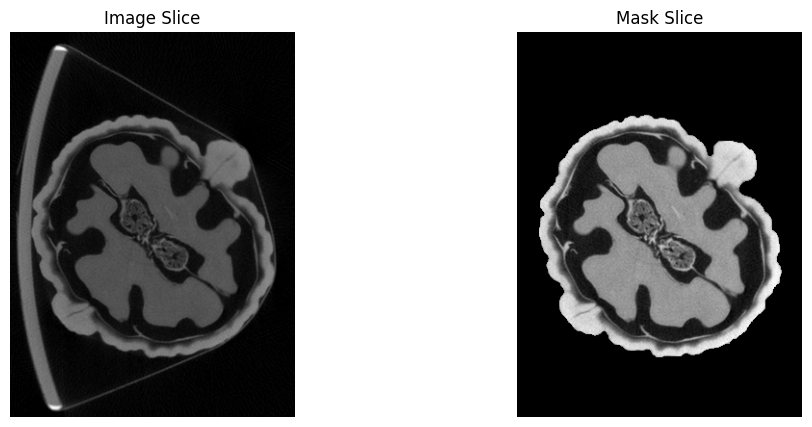

In [5]:
import matplotlib.pyplot as plt

slice_idx = image_volume.shape[2] // 2

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_volume[:, :, slice_idx], cmap='gray')
plt.title("Image Slice")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask_volume[:, :, slice_idx], cmap='gray')
plt.title("Mask Slice")
plt.axis("off")

plt.show()

In [6]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
import cv2

# Normalize and resize each 2D slice
image_slices = []
mask_slices = []

for i in range(image_volume.shape[2]):
    img_slice = image_volume[:, :, i]
    mask_slice = mask_volume[:, :, i]

    # Normalize to 0-1 range and resize
    img = cv2.resize(img_slice, (256, 256)) / 255.0
    mask = cv2.resize(mask_slice, (256, 256)) / 255.0

    image_slices.append(img)
    mask_slices.append(mask)

# Convert to numpy arrays
image_slices = np.array(image_slices)
mask_slices = np.array(mask_slices)

# Train/Val split
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_slices, mask_slices, test_size=0.2, random_state=42
)

# PyTorch Dataset
class MRIDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        mask = self.masks[idx]

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented['image'], augmented['mask']

        img = np.expand_dims(img, axis=0)
        mask = np.expand_dims(mask, axis=0)
        return torch.FloatTensor(img), torch.FloatTensor(mask)

# Albumentations transformations
transform = A.Compose([
    A.Rotate(limit=30, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3)
])

# Create datasets and loaders
train_dataset = MRIDataset(train_imgs, train_masks, transform=transform)
val_dataset = MRIDataset(val_imgs, val_masks)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print("Train set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))

Train set size: 281
Validation set size: 71


In [7]:
# Print shape of one item
sample_img, sample_mask = train_dataset[0]
print("Image shape:", sample_img.shape)
print("Mask shape:", sample_mask.shape)

Image shape: torch.Size([1, 256, 256])
Mask shape: torch.Size([1, 256, 256])


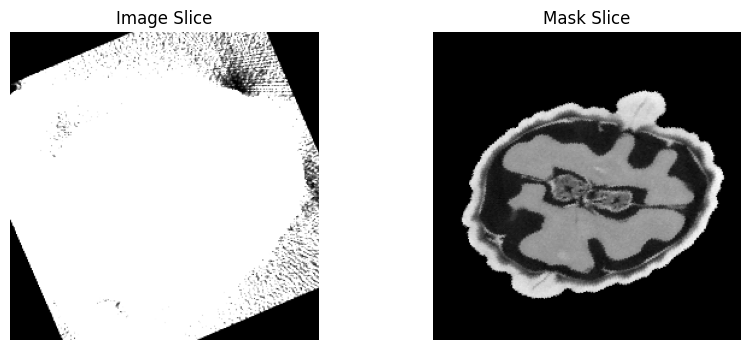

In [8]:
import matplotlib.pyplot as plt

# Get a sample
img_tensor, mask_tensor = train_dataset[0]

# Convert to numpy for plotting
img = img_tensor.squeeze().numpy()
mask = mask_tensor.squeeze().numpy()

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Image Slice")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask Slice")
plt.axis("off")

plt.show()

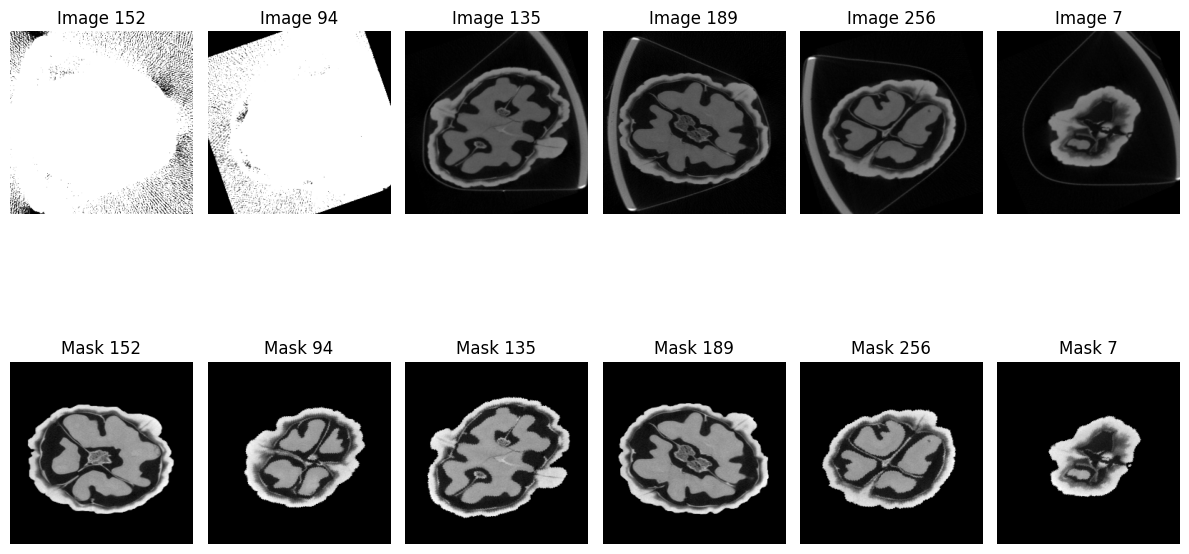

In [9]:
import random

plt.figure(figsize=(12, 8))
for i in range(6):
    idx = random.randint(0, len(train_dataset) - 1)
    img, mask = train_dataset[idx]
    img = img.squeeze().numpy()
    mask = mask.squeeze().numpy()

    plt.subplot(2, 6, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Image {idx}")
    plt.axis("off")

    plt.subplot(2, 6, i + 7)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Mask {idx}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# MobileNetV2-U-Net (pretrained encoder)

In [15]:
# 1) Optional but helpful
!pip install -q --upgrade pip

# 2) Install a compatible timm first (0.9.x), then SMP 0.3.3 without deps
!pip install -q "timm==0.9.2"
!pip install -q "segmentation-models-pytorch==0.3.3" --no-deps

In [16]:
# Install legacy deps SMP 0.3.x imports at module load
!pip install -q "pretrainedmodels==0.7.4" "efficientnet-pytorch==0.7.1"

In [17]:
# 3) (Optional) Verify versions
import timm, segmentation_models_pytorch as smp
print("timm:", timm.__version__)
print("smp:", smp.__version__)

timm: 0.9.16
smp: 0.3.3


In [18]:
import segmentation_models_pytorch as smp
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.net = smp.Unet(
            encoder_name="mobilenet_v2",
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=out_channels,
        )
    def forward(self, x):
        return self.net(x)  # logits (OK for BCEWithLogitsLoss)

In [19]:
# Test model instantiation
pytorch_model = UNet(in_channels=1, out_channels=1)
print(f"PyTorch model parameters: {sum(p.numel() for p in pytorch_model.parameters()):,}")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 206MB/s]


PyTorch model parameters: 6,628,369


# Train the Model with Gradient Monitoring

In [21]:
## Losses (BCE + DICE)

import torch
import torch.nn as nn

bce_logits = nn.BCEWithLogitsLoss()

def dice_loss_from_logits(logits, targets, eps=1e-6):
    # logits: (B,1,H,W); targets: (B,1,H,W) in {0,1}
    probs = torch.sigmoid(logits)
    num = 2 * (probs * targets).sum(dim=(2,3))
    den = (probs.pow(2) + targets.pow(2)).sum(dim=(2,3)) + eps
    return (1 - (num + eps) / den).mean()

def combo_loss(logits, targets, alpha=0.5):
    # alpha=0.5 => 0.5*BCE + 0.5*Dice
    return alpha * bce_logits(logits, targets) + (1 - alpha) * dice_loss_from_logits(logits, targets)


In [22]:
## Train loop with AMP, grad clipping, early stop, checkpoint

from torch.cuda.amp import autocast, GradScaler

def train_model(model, train_loader, val_loader, epochs=10, device='cuda', patience=5):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    scaler = GradScaler(enabled=(device.type=='cuda'))

    train_losses, val_losses, grad_norms = [], [], []
    best_val = float('inf')
    no_improve = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        last_grad_norm = 0.0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad(set_to_none=True)

            with autocast(enabled=(device.type=='cuda')):
                logits = model(images)
                loss = combo_loss(logits, masks)

            scaler.scale(loss).backward()
            # unscale before clipping
            scaler.unscale_(optimizer)
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            last_grad_norm = float(grad_norm)
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * images.size(0)
            grad_norms.append(last_grad_norm)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # ---- Validation ----
        model.eval()
        val_loss = 0.0
        with torch.no_grad(), autocast(enabled=(device.type=='cuda')):
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                logits = model(images)
                loss = combo_loss(logits, masks)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        scheduler.step()

        print(f"Epoch {epoch+1:02d}/{epochs} | Train {train_loss:.4f} | Val {val_loss:.4f} | GradNorm {last_grad_norm:.4f}")

        # ---- Checkpoint + early stop ----
        if val_loss < best_val - 1e-5:
            best_val = val_loss
            no_improve = 0
            torch.save(model.state_dict(), "best_seg_model.pth")
            print("  ↳ saved best checkpoint")
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping (no improvement for {patience} epochs). Best val loss: {best_val:.4f}")
                break

    # plot (kept same)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
    ax1.plot(train_losses, label='Train Loss', color='blue')
    ax1.plot(val_losses, label='Val Loss', color='orange')
    ax1.set_title('Loss Over Epochs'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)

    ax2.plot(grad_norms, color='purple', label='Gradient Norm')
    ax2.set_title('Gradient Norms'); ax2.set_xlabel('Iteration'); ax2.set_ylabel('Grad Norm'); ax2.legend(); ax2.grid(True)
    plt.savefig("training_metrics.png", dpi=300); plt.show()

    return train_losses, val_losses, grad_norms


Epoch 1/10: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s]


Epoch 01/10 | Train -12.9517 | Val -79.6983 | GradNorm 57.2802
  ↳ saved best checkpoint


Epoch 2/10: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]


Epoch 02/10 | Train -32.4851 | Val -76.3355 | GradNorm 67.3514


Epoch 3/10: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]


Epoch 03/10 | Train -53.9090 | Val -85.1308 | GradNorm 68.0487
  ↳ saved best checkpoint


Epoch 4/10: 100%|██████████| 36/36 [00:22<00:00,  1.57it/s]


Epoch 04/10 | Train -75.4121 | Val -80.9655 | GradNorm 85.4900


Epoch 5/10: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]


Epoch 05/10 | Train -96.0077 | Val -151.3309 | GradNorm 118.7774
  ↳ saved best checkpoint


Epoch 6/10: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]


Epoch 06/10 | Train -114.0357 | Val -135.3226 | GradNorm 77.2563


Epoch 7/10: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]


Epoch 07/10 | Train -125.6353 | Val -138.0593 | GradNorm 95.2874


Epoch 8/10: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]


Epoch 08/10 | Train -133.9229 | Val -163.5622 | GradNorm 88.2458
  ↳ saved best checkpoint


Epoch 9/10: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]


Epoch 09/10 | Train -140.9130 | Val -153.1765 | GradNorm 93.7025


Epoch 10/10: 100%|██████████| 36/36 [00:22<00:00,  1.57it/s]


Epoch 10/10 | Train -142.8888 | Val -153.7184 | GradNorm 90.6362


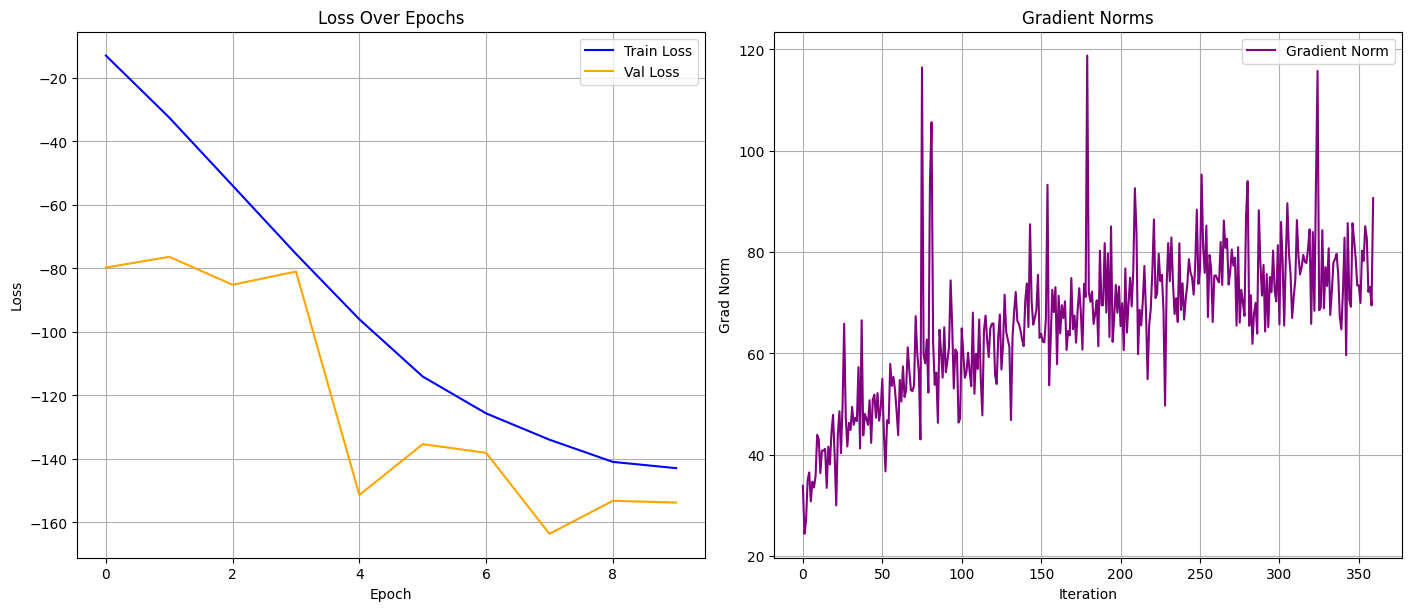

<All keys matched successfully>

In [26]:
## Run Training + Evaluation
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
from scipy.stats import ttest_ind

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pytorch_model = UNet(in_channels=1, out_channels=1)

train_losses, val_losses, grad_norms = train_model(
    pytorch_model, train_loader, val_loader, epochs=10, device=device, patience=5
)

# Load best before evaluation (optional but recommended)
pytorch_model.load_state_dict(torch.load("best_seg_model.pth", map_location=device))

In [32]:
## Fast eval (Dice/IoU in torch)
def evaluate_model(model, loader, device='cuda', thr=0.5):
    model.eval()
    dice_scores, iou_scores = [], []
    accs, precs, recs, f1s = [], [], [], []

    eps = 1e-6
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            logits = model(images)
            probs = torch.sigmoid(logits)
            preds = (probs > thr).float()

            B = images.size(0)
            for b in range(B):
                p = preds[b, 0]       # (H, W) float {0,1}
                t = masks[b, 0]       # (H, W) float {0,1}

                # basic sums
                p_sum = p.sum().item()
                t_sum = t.sum().item()
                inter = (p * t).sum().item()
                union = (p + t - p * t).sum().item() + eps

                # Dice / IoU
                dice = (2 * inter + eps) / (p_sum + t_sum + eps)
                iou  = (inter + eps) / union
                dice_scores.append(dice)
                iou_scores.append(iou)

                # Accuracy, Precision, Recall, F1 from TP/FP/FN
                tp = inter
                fp = (p_sum - inter)
                fn = (t_sum - inter)
                tn = (p.numel() - (tp + fp + fn))  # not used but fine

                acc = (tp + tn) / (p.numel() + eps)
                # Handle empty cases gracefully
                prec = tp / (tp + fp + eps)
                rec  = tp / (tp + fn + eps)
                f1   = 2 * prec * rec / (prec + rec + eps)

                accs.append(float(acc))
                precs.append(float(prec))
                recs.append(float(rec))
                f1s.append(float(f1))

    return {
        "Dice": float(np.mean(dice_scores)), "Dice_std": float(np.std(dice_scores)),
        "IoU": float(np.mean(iou_scores)),   "IoU_std":  float(np.std(iou_scores)),
        "Accuracy": float(np.mean(accs)),    "Accuracy_std": float(np.std(accs)),
        "Precision": float(np.mean(precs)),  "Precision_std": float(np.std(precs)),
        "Recall": float(np.mean(recs)),      "Recall_std": float(np.std(recs)),
        "F1": float(np.mean(f1s)),           "F1_std": float(np.std(f1s)),
        "All": {
            "Dice": dice_scores, "IoU": iou_scores, "Accuracy": accs,
            "Precision": precs, "Recall": recs, "F1": f1s
        }
    }


      Metric       Mean       Std
0       Dice   1.694508  0.560887
1        IoU  14.468898  5.201578
2   Accuracy   5.555547  2.709363
3  Precision  14.494874  5.195076
4     Recall   0.901259  0.298064
5         F1   1.694508  0.560887


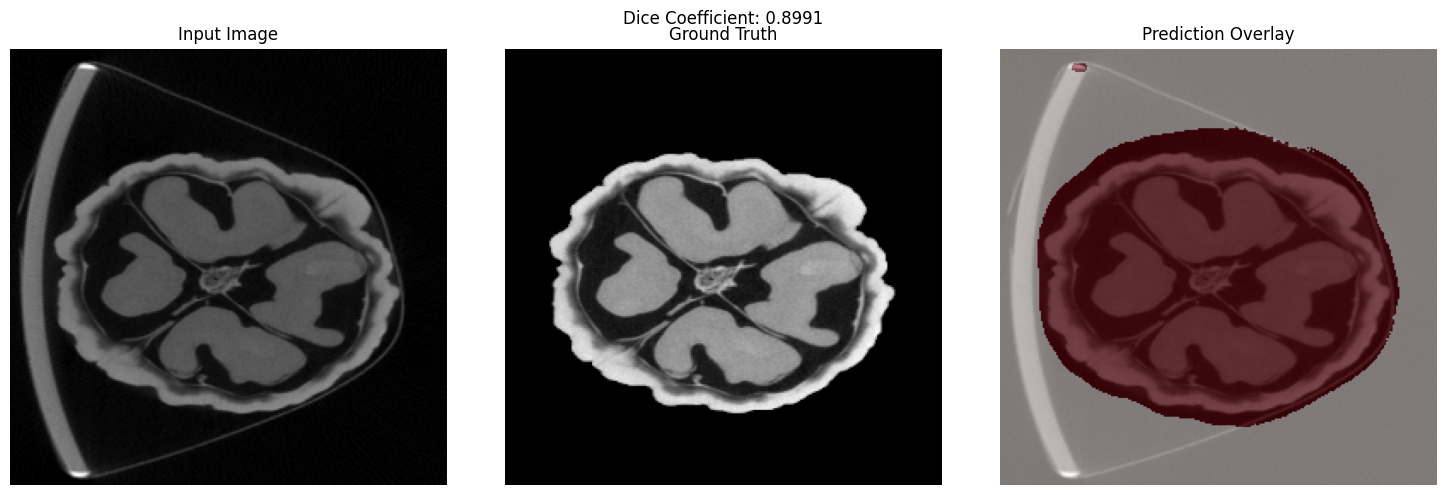

In [34]:
metrics = evaluate_model(pytorch_model, val_loader, device=device)
metrics_df = pd.DataFrame({
    'Metric': ['Dice', 'IoU', 'Accuracy', 'Precision', 'Recall', 'F1'],
    'Mean': [metrics[k] for k in ['Dice', 'IoU', 'Accuracy', 'Precision', 'Recall', 'F1']],
    'Std': [metrics[f"{k}_std"] for k in ['Dice', 'IoU', 'Accuracy', 'Precision', 'Recall', 'F1']]
})
print(metrics_df)
metrics_df.to_csv("evaluation_metrics.csv", index=False)

def dice_coefficient(y_true, y_pred, thr=0.5, eps=1e-6):
    y_true_f = (y_true > thr).astype(np.uint8).flatten()
    y_pred_f = (y_pred > thr).astype(np.uint8).flatten()
    inter = (y_true_f * y_pred_f).sum()
    return (2. * inter + eps) / (y_true_f.sum() + y_pred_f.sum() + eps)


# Visualize Prediction Overlay
def visualize_prediction(model, dataset, device='cuda', idx=0):
    model.eval()
    img, mask = dataset[idx]
    img_tensor = img.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = torch.sigmoid(model(img_tensor)).squeeze().cpu().numpy()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img.squeeze(), cmap='gray')
    axes[0].set_title('Input Image')

    axes[1].imshow(mask.squeeze(), cmap='gray')
    axes[1].set_title('Ground Truth')

    axes[2].imshow(img.squeeze(), cmap='gray')
    axes[2].imshow(pred > 0.5, alpha=0.5, cmap='Reds')
    axes[2].set_title('Prediction Overlay')

    for ax in axes:
        ax.axis('off')

    dice = dice_coefficient(mask.squeeze().numpy(), pred)
    plt.suptitle(f'Dice Coefficient: {dice:.4f}')
    plt.tight_layout()
    plt.show()

visualize_prediction(pytorch_model, val_dataset, device=device, idx=0)



In [35]:
def sweep_threshold(model, loader, device='cuda', steps=21):
    thrs = np.linspace(0.1, 0.9, steps)
    dices = []
    for t in thrs:
        m = evaluate_model(model, loader, device=device, thr=float(t))
        dices.append(m['Dice'])
    best_i = int(np.argmax(dices))
    return float(thrs[best_i]), float(dices[best_i])

best_thr, best_dice = sweep_threshold(pytorch_model, val_loader, device=device)
print(f"Best threshold ~ {best_thr:.2f} | Dice {best_dice:.4f}")

Best threshold ~ 0.90 | Dice 1.7385


In [41]:
## ---- Quick training summary ----
if len(train_losses) and len(val_losses):
    last_train = train_losses[-1]
    last_val   = val_losses[-1]
    best_val   = min(val_losses)
    best_epoch = val_losses.index(best_val) + 1  # 1-based

    print(f"Final Training Loss (last epoch): {last_train:.6f}")
    print(f"Final Validation Loss (last epoch): {last_val:.6f}")
    print(f"Best Validation Loss: {best_val:.6f} (at epoch {best_epoch})")
    print("")

    # Extra plain prints (your request)
    print("Final Training Loss:", last_train)
    print("Final Validation Loss:", last_val)
    print("")
else:
    print("No losses recorded — check your training loop.")

if len(grad_norms):
    gmin, gmax, gmed = min(grad_norms), max(grad_norms), np.median(grad_norms)
    print(f"Grad Norm — min: {gmin:.4f}, max: {gmax:.4f}, median: {gmed:.4f}")
    print("")

    # Extra plain prints
    print("Max Gradient Norm:", gmax)
    print("Min Gradient Norm:", gmin)
    print("")
else:
    print("No gradient norms recorded — check grad logging.")

# Threshold sweep info (from earlier)
print(f"Best threshold: {best_thr:.2f} | Val Dice at best thr: {best_dice:.4f}")


Final Training Loss (last epoch): -142.888819
Final Validation Loss (last epoch): -153.718398
Best Validation Loss: -163.562163 (at epoch 8)

Final Training Loss: -142.88881908701833
Final Validation Loss: -153.71839818820146

Grad Norm — min: 24.3800, max: 118.7774, median: 67.3693

Max Gradient Norm: 118.77738952636719
Min Gradient Norm: 24.38004493713379

Best threshold: 0.90 | Val Dice at best thr: 1.7385


In [42]:
plt.savefig('training_metrics.png', dpi=900, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

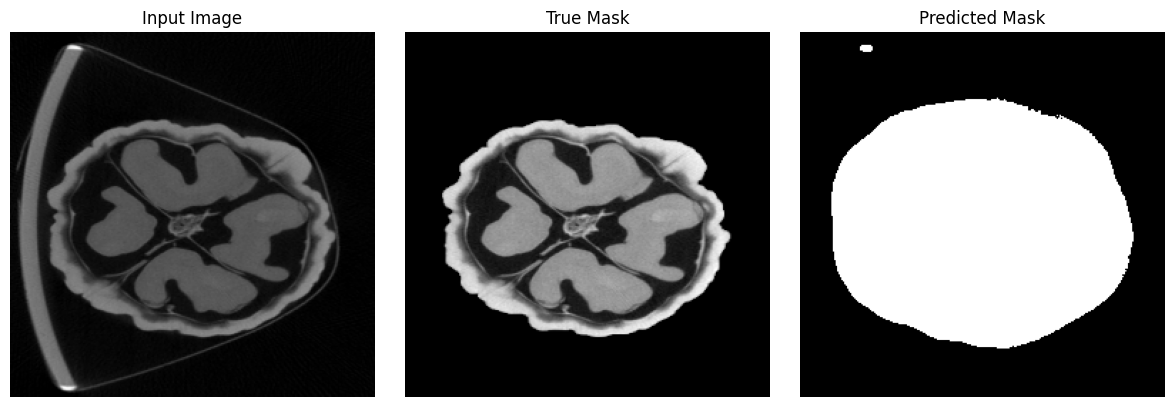

In [43]:
# Sample inference and plot
pytorch_model.eval()
with torch.no_grad():
    img, true_mask = val_dataset[0]
    img = img.unsqueeze(0).to(device)
    pred_mask = torch.sigmoid(pytorch_model(img)).squeeze().cpu().numpy()
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img.squeeze().cpu().numpy(), cmap='gray')
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(true_mask.squeeze().numpy(), cmap='gray')
plt.title("True Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred_mask > 0.5, cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

# Numerical Stability Analysis

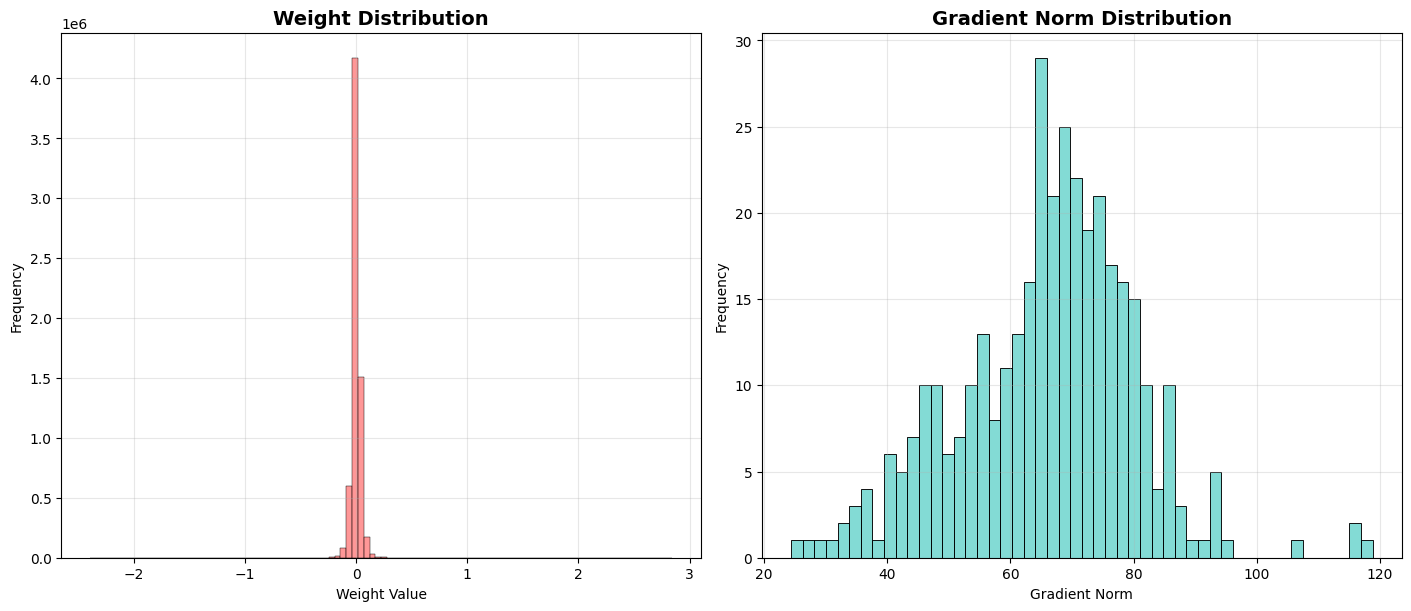


🔍 Numerical Stability Stats:
Weight Mean: 0.0005
Weight Std: 0.0448
Weight Kurtosis: 302.8388
Weight Skewness: 9.3683
Grad Norm Mean: 65.9432
Grad Norm Std: 14.3727


In [45]:
## Numerical Stability Analysis
def analyze_numerical_stability(model, grad_norms):
    weights = np.concatenate([
        param.detach().cpu().numpy().flatten()
        for name, param in model.named_parameters()
        if 'weight' in name and param.requires_grad
    ])

    stats = {
        'Weight Mean': np.mean(weights),
        'Weight Std': np.std(weights),
        'Weight Kurtosis': kurtosis(weights),
        'Weight Skewness': skew(weights),
        'Grad Norm Mean': np.mean(grad_norms) if grad_norms else float('nan'),
        'Grad Norm Std': np.std(grad_norms) if grad_norms else float('nan')
    }

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

    sns.histplot(weights, bins=100, ax=ax1, color='#FF6B6B', alpha=0.7)
    ax1.set_title('Weight Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Weight Value')
    ax1.set_ylabel('Frequency')
    ax1.grid(True, alpha=0.3)

    sns.histplot(grad_norms, bins=50, ax=ax2, color='#4ECDC4', alpha=0.7)
    ax2.set_title('Gradient Norm Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Gradient Norm')
    ax2.set_ylabel('Frequency')
    ax2.grid(True, alpha=0.3)

    plt.savefig('numerical_stability.png', dpi=300)
    plt.show()

    return stats

# Analyze numerical stability
numerical_stats = analyze_numerical_stability(pytorch_model, grad_norms)
print("\n🔍 Numerical Stability Stats:")
for k, v in numerical_stats.items():
    print(f"{k}: {v:.4f}")

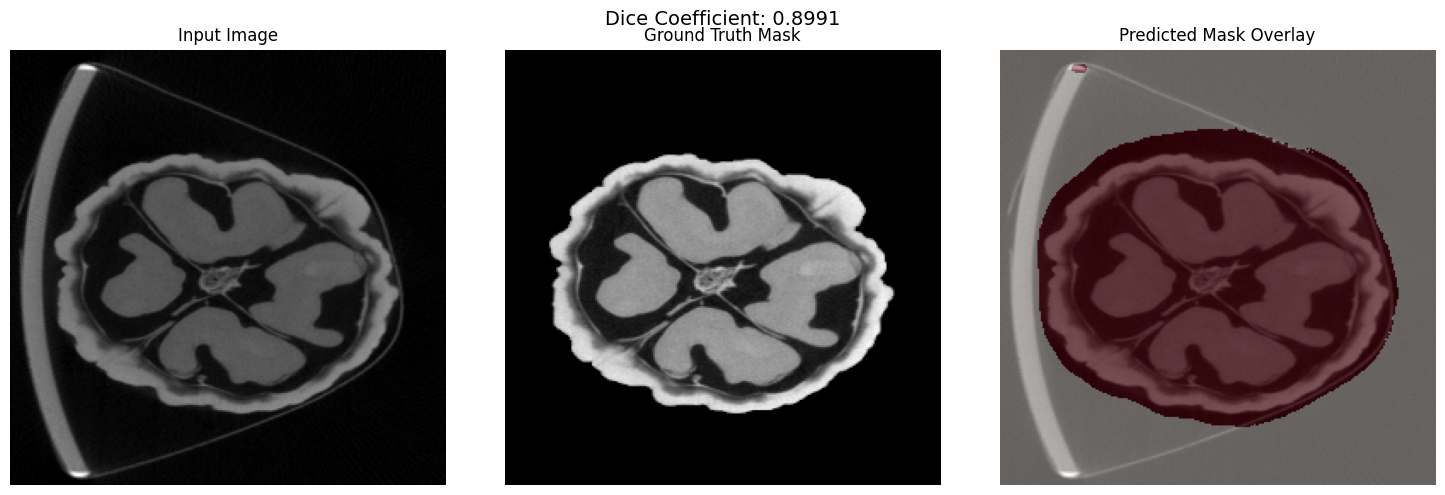

In [46]:
def visualize_prediction(model, dataset, device='cuda', idx=0):
    model.eval()
    img, true_mask = dataset[idx]
    img_tensor = img.unsqueeze(0).to(device)
    
    with torch.no_grad():
        pred_mask = torch.sigmoid(model(img_tensor)).squeeze().cpu().numpy()
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(img.squeeze().cpu().numpy(), cmap='gray')
    axes[0].set_title('Input Image')
    
    axes[1].imshow(true_mask.squeeze().numpy(), cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    
    axes[2].imshow(img.squeeze().cpu().numpy(), cmap='gray')
    axes[2].imshow(pred_mask > 0.5, alpha=0.4, cmap='Reds')
    axes[2].set_title('Predicted Mask Overlay')
    
    for ax in axes:
        ax.axis('off')
    
    dice = dice_coefficient(true_mask.squeeze().numpy(), pred_mask)
    plt.suptitle(f'Dice Coefficient: {dice:.4f}', fontsize=14)
    plt.tight_layout()
    plt.show()

# Example usage
visualize_prediction(pytorch_model, val_dataset, device=device, idx=0)

# Segmentation Visualization

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def visualize_segmentation(model,
                           loader,
                           device='cuda',
                           num_samples=3,
                           thr=0.5,
                           postprocess=False,      # requires _largest_cc(mask)
                           savepath='segmentation_results.png',
                           show_scores=True):
    model.eval()
    images_shown = 0
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples), constrained_layout=True)
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)

    eps = 1e-6
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            logits = model(images)
            probs  = torch.sigmoid(logits).cpu().numpy()  # (B,1,H,W)

            B = images.shape[0]
            for i in range(B):
                if images_shown >= num_samples:
                    break

                # image (normalize for display)
                img = images[i, 0].detach().cpu().numpy()
                img_disp = (img - img.min()) / (img.max() - img.min() + 1e-8)

                # ---- GT exactly as you requested ----
                mask = masks[i].detach().cpu()             # (1,H,W)
                true_mask = mask[0].numpy()                # <-- your requirement

                # prediction
                prob_map  = probs[i, 0]
                pred_mask = (prob_map > float(thr)).astype(np.uint8)

                if postprocess:
                    pred_mask = _largest_cc(pred_mask)

                # metrics on a binarized copy of GT (display remains as-is)
                gt_bin = (true_mask > 0.5).astype(np.uint8)
                inter  = (pred_mask & gt_bin).sum()
                union  = (pred_mask | gt_bin).sum() + eps
                iou    = (inter + eps) / union

                # re-use your helper (it thresholds internally)
                dice   = dice_coefficient(true_mask, pred_mask, thr=0.5)

                row = axes[images_shown]
                row[0].imshow(img_disp, cmap='gray'); row[0].set_title('Input MRI', fontsize=12)
                row[1].imshow(true_mask, cmap='gray', interpolation='nearest'); row[1].set_title('Ground Truth', fontsize=12)
                row[2].imshow(img_disp, cmap='gray')
                row[2].imshow(pred_mask, alpha=0.4, cmap='Reds', interpolation='nearest')
                ttl = 'Predicted Mask'
                if show_scores:
                    ttl += f' (Dice {dice:.3f}, IoU {iou:.3f}, thr={thr:.2f})'
                row[2].set_title(ttl, fontsize=12)

                for ax in row: ax.axis('off')
                images_shown += 1

            if images_shown >= num_samples:
                break

    plt.savefig(savepath, dpi=900, bbox_inches='tight')
    plt.show()


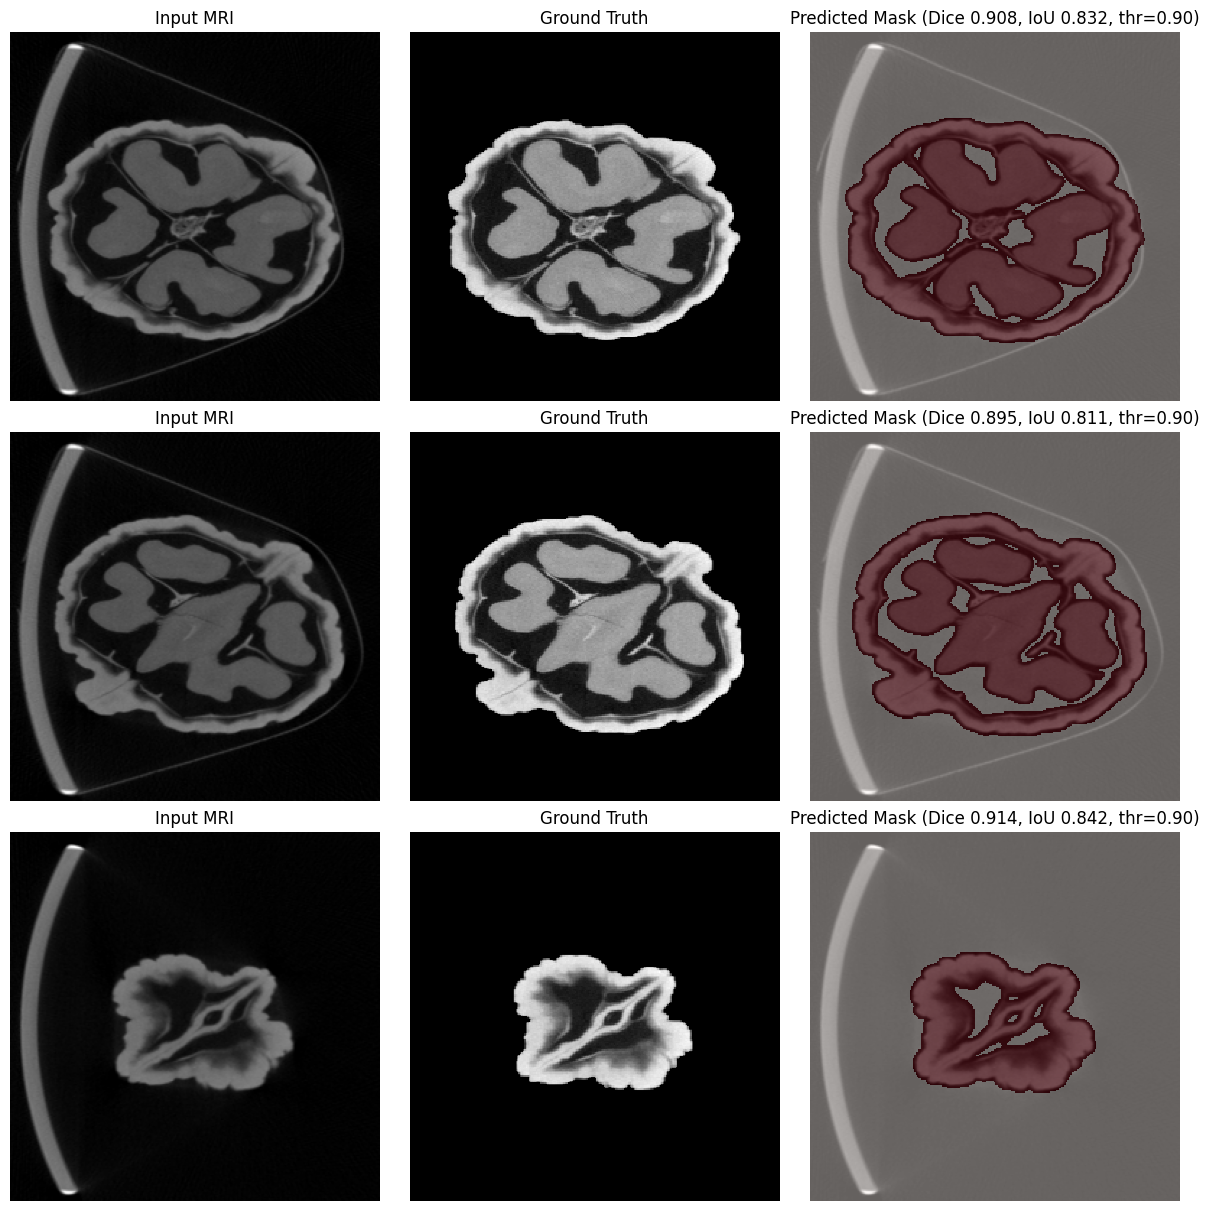

In [66]:
visualize_segmentation(
    pytorch_model, val_loader, device=device,
    num_samples=3, thr=best_thr, postprocess=True
)